In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

# For presentations purposes only (not needed in Colab)
plt.style.use('notebook.mplstyle')
# Keeps the kernel from dying in notebooks on Windows machines (not needed in Colab)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Solving differential equations with neural networks
Physics-informed machine learning refers to various ways of providing machine learning models with knowledge about the underlying physics. A typical example is physics-informed neural networks (PINNs), where knowledge about physical laws (in the form of differential equations) are incorporated into the objective function. From one view point, these networks can be interpreted as a very versatile approach for solving differential equations. To better understand the logic, lets first assume we have the following differential equation:

\begin{equation}
 \frac{df(x)}{dx} = x
\end{equation}

and that our aim is to learn $f(x)$. Since neural networks are universal approximators, it follows that a neural network should be able to approximate $f(x)$. However, we need a way to ensure that the network learns the sought function $f(x)$ and not something else, and this is accomplished by defining an objective (loss) functions that is zero whenever the differential equation is satisfies and non-zero otherwise. This can accomplished by simply defining the loss as:

\begin{equation}
 loss = \frac{1}{N} \sum_{n=1}^N \left( \frac{df_{NN}(x_n)}{dx_n} - x_n \right)^2,
\end{equation}

where $x_n$ for $n \in 1, ..., N$ denotes $N$ different $x$ values (e.g. linearly spaced) and $f_{NN}$ the function approximated by the neural network. In other words, we evaluate the network at $N$ locations in a region of interest, compute the derivative at each location, and finally penalize approximated functions that don't satisfy our given differential equation that we wanted to solve. In order to find a unique solution, we still need to define an "initial" value, for example $f(0)=0$, but this constraint can simply be added to the objective function in a similar fashion as:

\begin{equation}
 loss = \frac{1}{N} \sum_{n=1}^N \left( \frac{df_{NN}(x_n)}{dx_n} - x_n \right)^2 + f_{NN}(0)^2.
\end{equation}

In summary, we have now defined an objective function for which the wanted $f(x)$ reaches a minimum value. The full optimization problem is nonetheless non-convex as we try to approximate $f(x)$ with a neural network, and there is thus no guarantee that we actually find a arbitrarily good approximation for $f(x)$. However, experiments have shown that the approach seems to work in practice, and consequently, PINNs have aroused some interest lately as the approach is easy to combine with experimental data and as data can be used to compensate for unknown parameters in the physical laws (differential equations).

### Neural networks and derivatives
Before we can run an example to exemplify the PINN approach outlined above, we first need to 1) define a neural network and 2) find a way of evaluating the derivatives in the objective function. Regarding point one, there has not really been much research yet on investigating the best network structures for solving general differential equations, and consequently, people have defaulted to using fully-connected multi-layer perceptron (MLP) networks. And regarding point two, we are actually in luck. The same automatic differentiation packages that were developed to compute gradients for adjusting the parameters of neural networks can equally well be used to compute the derivatives needed for evaluating the objective function. PINNs are thus in some sense a bit of a side product made possible by modern neural network packages, like PyTorch and TensorFLow, as they come with the necessary tools.

The examples below are based on PyTorch and its autograd package for computing derivatives. First, we nonetheless define a neural network approximator class as well as couple of functions for evaluating the network and for computing derivatives.

In [2]:
# The code below is partly copied from: https://github.com/madagra/basic-pinn

class NNApproximator(torch.nn.Module):
    """Defines a neural network funtion approximator based on a MLP structure"""
    
    def __init__(self, num_hidden: int, dim_hidden: int, act_fun=torch.nn.Tanh()):
        """Define the dimensions, layers and activation functions"""
        super().__init__()

        self.layer_in = torch.nn.Linear(1, dim_hidden)
        self.layer_out = torch.nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        layer_list = [torch.nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        self.middle_layers = torch.nn.ModuleList(layer_list)
        
        self.act_fun = act_fun

    def forward(self, x):
        """Define the computations for the forward pass through the network"""
        # input --> to first hidden layer
        out = self.act_fun(self.layer_in(x))
        # first --> last hidden layer
        for layer in self.middle_layers:
            out = self.act_fun(layer(out))
        # last hidden layer --> ouput 
        return self.layer_out(out)
    
def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)

def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivatives with respect to inputs using PyTorch's autograd engine"""
    
    df_values = []
    df_values.append(f(nn, x))
    for i in range(order):
        df_value_tmp = torch.autograd.grad(
            df_values[i], 
            x, 
            grad_outputs=torch.ones_like(x), 
            create_graph=True
        )[0]
        df_values.append(df_value_tmp)

    return df_values

### Example 1. Solving a differential equation with a neural network
Let's start off by solving the simple differential equation $\frac{df(x)}{dx} = x$ with a neural network. We will pick the interval $0 \leq x \leq2$ to be our region of interest and define 25 linearly spaced locations within it over which we evaluate our objective function. As this is a very simple differential equation, it has a known analytical solution: $\frac{1}{2}x^2$ against which we can compare our out from the neural network.

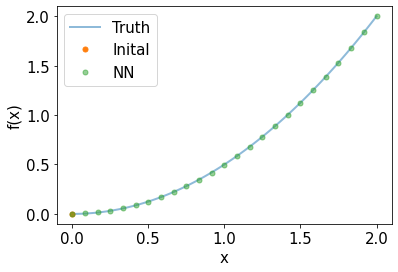

In [3]:
# Define the 25 linearly spaced x-values
x_grad = torch.linspace(0, 2, 25).reshape(25, 1)
# Turn on the require_grad flag
x_grad.requires_grad = True

# Define a neural network with 3 hidden layers and 20 nodes per layer
nn = NNApproximator(3, 20)

# Initialize
loss = []
n_epochs = 200
# Use Adan as the optimizer
optimizer = torch.optim.Adam(nn.parameters(), lr=1e-2)

# Loop over all epochs
for epoch in range(n_epochs):
    
    # Compute the derivatives for each input (x) value
    fx, dfx = df(nn, x_grad, order=1)
    # Evaluate the objective function
    loss_tmp = torch.mean( (dfx - x_grad)**2 ) + (f(nn, torch.zeros(1, 1))-0)**2
    
    # Save the current loss value
    loss.append(loss_tmp.detach().numpy())
    
    # Take a gradient descent step
    optimizer.zero_grad()
    loss_tmp.backward()
    optimizer.step()

# Plot the analytical solution for comaprison
x = np.linspace(0, 2, 100)
plt.plot(x, 0.5*x**2, '-', alpha=0.5, label='Truth')
# the inital value f(0) = 0
plt.plot(0, 0, '.', label='Inital')
# and the output from the network
plt.plot(x_grad.detach(), f(nn, x_grad).detach(), '.', alpha=0.5, label='NN')
# Add labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend();

### Example 2. Damped harmonic oscillator
Having seen the basic idea, let's next look at a more interesting example in the form of a [damped harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator):

\begin{equation}
 m\frac{d^2x(t)}{dt^2} + c\frac{dx(t)}{dt} + kx(t) = 0, 
\end{equation}

where $m$ denotes the mass, $c$ the damping coefficient, $k$ the spring constant and $x(t)$ the position of the oscillator at time $t$. There exists an analytical solution for this school book example as well (see the [wiki](https://en.wikipedia.org/wiki/Harmonic_oscillator) page for details) and below we plot it for a given set of parameters.

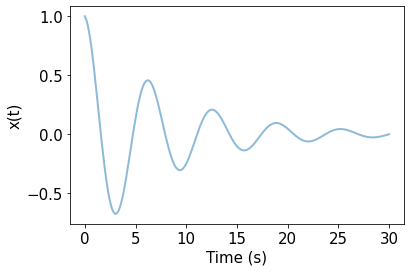

In [4]:
c = 0.25  # Damping coefficient
k = 1     # Spring constant
m = 1     # Mass
A = 1     # Amplitude at t=0

beta = c / 2 / m                         # Damping parameter
omega_0 = np.sqrt(k/m)                   # Charecteristic frequency of undamped system
omega_1 = np.sqrt(omega_0**2 - beta**2)  # Charecteristic frequency of underdamped systems

assert omega_0**2 > beta**2  # Ensures that we have an underdamped system

def analytical_solution(t: torch.Tensor) -> torch.Tensor:
    """Underdamped harmonic oscillator"""
    return A*torch.exp(-beta*t)*torch.cos(omega_1*t)

# Plot the analytical solution
t = torch.linspace(0, 30, 200)
plt.plot(t, analytical_solution(t), '-', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('x(t)');

Next we illustrate how versatile PINNs are by highlight how to deal with a more real-life like scenario where we might not have access to initial conditions, but rather some noisy observations at a few points in time (observational data).

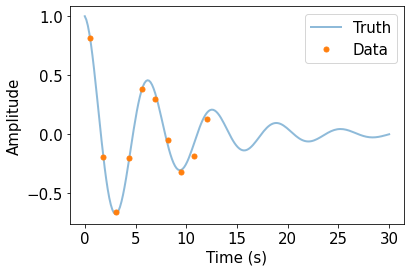

In [18]:
t_data = torch.linspace(0.5, 12, 10).reshape(10, 1)
y_data = analytical_solution(t_data)
y_data = y_data + 0.1*torch.randn_like(y_data)
plt.plot(t, analytical_solution(t), '-', alpha=0.5, label='Truth')
plt.plot(t_data, y_data, '.', label='Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend();

In the previous example, we included initial conditions into the objective function to constrain the functions satisfying our physical laws, but the initial conditions can equally well be replaced with observational data. That is, we modify the loss function accordingly:

\begin{equation}
 loss = \frac{1}{N} \sum_{n=1}^N \left( \frac{df_{NN}(t_n)}{dt_n} - x_n \right)^2 + \frac{1}{M} \sum_{m=1}^M \left( f_{NN}(t_m) - x_m \right)^2.
\end{equation}

where $n \in 1, ..., N$ denotes the time points at which the physical laws are evaluated, and $m \in 1, ..., m$ indexes the time points for which we have observational data $(x_t)$.

epoch:     0
epoch:  1000
epoch:  2000
epoch:  3000
epoch:  4000
epoch:  5000
epoch:  6000
epoch:  7000
epoch:  8000
epoch:  9000
epoch: 10000
epoch: 11000
epoch: 12000
epoch: 13000
epoch: 14000
epoch: 15000
epoch: 16000
epoch: 17000
epoch: 18000
epoch: 19000


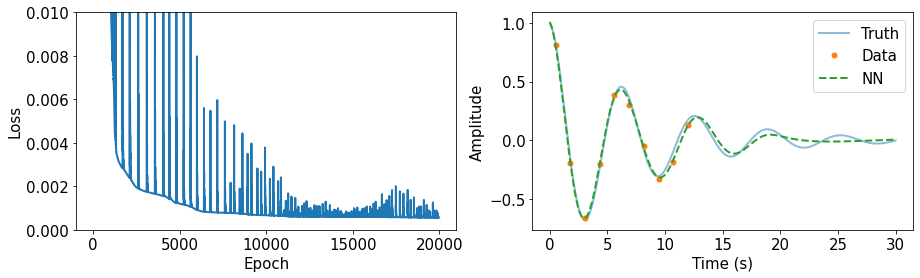

In [19]:
# Define N (50) linearly spaced t-values for evaluating the physical laws
t_grad = torch.linspace(0, 30, 100).reshape(100, 1)
t_grad.requires_grad = True

# Create a network for approximating the solution
nn = NNApproximator(3, 20)

# Initialize
loss = []
n_epochs = 20000
optimizer = torch.optim.Adam(nn.parameters(), lr=5e-3)

# Loop over all epochs
for epoch in range(n_epochs):
    
    # Evaluate the position, the velocity and the acceleration at each time point
    pos_dense, vel_dense, acc_dense = df(nn, t_grad, order=2)
    # Compute the physics loss (violation of the known governing equation for a damped harmonic oscillator)
    physics_loss = torch.mean( (m*acc_dense + c*vel_dense + k*pos_dense)**2 )
    # Compute the prediction loss from not comforming to the observed data
    prediction_loss = torch.mean( (f(nn, t_data) - y_data)**2 )
    
    # Sum up the total loss
    total_loss = prediction_loss + 1*physics_loss
    loss.append(total_loss.detach())
    
    # Update the weights of the network
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"epoch: {epoch:>5d}")
        
# plot the results
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Visualize how the loss changed during training
axs[0].plot(np.arange(n_epochs), loss)
axs[0].set(xlabel='Epoch', ylabel='Loss', ylim=[0, 1e-2])

# Visualize the approximated function
y_nn = f(nn, t.reshape(t.size()[0], 1))
axs[1].plot(t, analytical_solution(t), '-', alpha=0.5, label='Truth')
axs[1].plot(t_data, y_data, '.', label='Data')
axs[1].plot(t, y_nn.detach(), '--', label='NN')
axs[1].set(xlabel='Time (s)', ylabel='Amplitude')
axs[1].legend();

The solution found by the neural network does not exactly match the analytical solution, as it is matched to the noisy observations rather than to known initial conditions. Nonetheless, it is clear that the found solution seems realistic and that the PINN is able to make reasonable predictions even outside of the region with observed data.

### Example 3. Inverse problem, estimating model parameters
As a final example, we will continue with the damped harmonic oscillator example above, but extend it to also estimate model parameters. More precisely, we will assume that the mass of the oscillator is unknown and that it needs to be estimated from the observational data as well. Intriguingly, PINNs can inherently handle parameter estimation without any modifications to the objective function. Instead, the sought model parameters are simply treated as parameters that are to be estimated alongside the parameters (weights) of the neural network. That is, the same machinery that is used to find good parameter values for the neural network can also be used to estimate the sought model parameters as a parallel task. This is highlighted by the example below.

epoch:     0
epoch:  1000
epoch:  2000
epoch:  3000
epoch:  4000
epoch:  5000
epoch:  6000
epoch:  7000
epoch:  8000
epoch:  9000
epoch: 10000
epoch: 11000
epoch: 12000
epoch: 13000
epoch: 14000
epoch: 15000
epoch: 16000
epoch: 17000
epoch: 18000
epoch: 19000


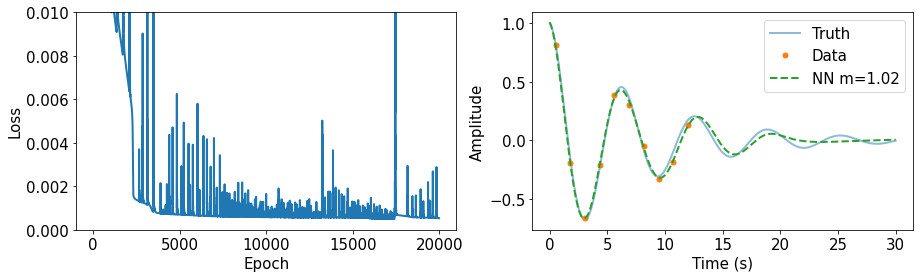

In [20]:
# Define a tesnor (initial guess) for the mass and turn on 
# require_grad so that autograd computes the derivative for it.
m_var = torch.tensor([0.25], requires_grad=True)

nn = NNApproximator(3, 20)

# Initialize
loss = []
n_epochs = 20000
# Chain the model parameter to the network parameters so that the 
# optimizer adjusts in parallel with the network parameters.
optimizer = torch.optim.Adam(chain(nn.parameters(), [m_var]), lr=1e-2)

# Loop over all epochs
for epoch in range(n_epochs):
    
    # Evaluate the position, the velocity and the acceleration at each time point
    pos_dense, vel_dense, acc_dense = df(nn, t_grad, order=2)
    # Compute the physics loss (violation of the known governing equation for a damped harmonic oscillator)
    # Make sure to use the current estimate of the mass!!!
    physics_loss = torch.mean( (m_var*acc_dense + c*vel_dense + k*pos_dense)**2 )
    # Compute the prediction loss from not comforming to the observed data
    prediction_loss = torch.mean( (f(nn, t_data) - y_data)**2 )
    
    # Sum up the total loss
    total_loss = prediction_loss + 1*physics_loss
    loss.append(total_loss.detach())
    
    # Update the weights of the network
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"epoch: {epoch:>5d}")
        
# plot the results
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Visualize how the loss changed during training
axs[0].plot(np.arange(n_epochs), loss)
axs[0].set(xlabel='Epoch', ylabel='Loss', ylim=[0, 1e-2])

# Visualize the approximated function
y_nn = f(nn, t.reshape(t.size()[0], 1))
axs[1].plot(t, analytical_solution(t), '-', alpha=0.5, label='Truth')
axs[1].plot(t_data, y_data, '.', label='Data')
axs[1].plot(t, y_nn.detach(), '--', label=f'NN m={m_var.detach()[0]:>2.2f}')
axs[1].set(xlabel='Time (s)', ylabel='Amplitude')
axs[1].legend();

The real value for $m$ was 1 and even if we don't get exactly that value (the observations are noisy) we clearly get close.

In summary, we have seen that PINNs constitute a very versatile approach for solving differential equations. One can easily incorporate known physics by simply modifying the objective function, and this in turn makes it possible to make realistic model predictions and even to estimate unknown model parameters.